# ***`Drug Consumption Habit Modeling with LIWC`***
---
#### 1. **Dataset Preparation:**
#### 2. **EDA & Feature Selection**
#### 3. **Target Drugs**
---

## Base Libraries
---

In [3]:
import pandas as pd

# enable to see all columns:
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

import shap

from typing import List, Any
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Helper Functions
---

In [4]:
from helper_functions import *

The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


## **1) Data Set Preparation**
---

### 1.1) Read Data:

In [ ]:
df = pd.read_parquet("merged_data/df_cascade_consumption_liwc.parquet")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print()
display_data_shape(df)
df.head()

### 1.2) Filter Based on word count (WC)?

In [37]:
df['WC'].describe()

count     1185.000000
mean      2751.443038
std       3817.688675
min          1.000000
25%        572.000000
50%       1548.000000
75%       3496.000000
max      45253.000000
Name: WC, dtype: float64

Minimum word count: 1


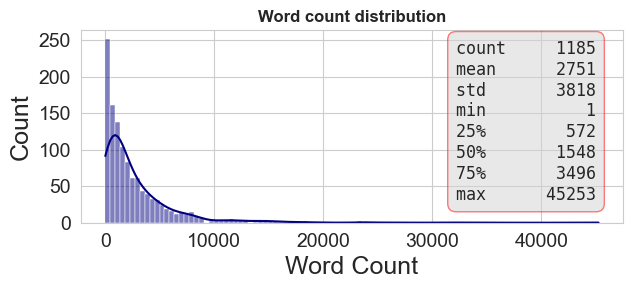

In [38]:
plt.figure(figsize=(7, 2.5))
plt.title('Word count distribution', weight='bold')
sns.histplot(
        x='WC', data=df,
        kde=True, bins=100,
        color='navy',
        # make kde line red
        line_kws={'color': 'red', 'lw': 1.5}
)
# include summary statistics as label in plot:
plt.text(
        x=0.95, y=0.95,
        s=df['WC'].describe().round(0).astype(int).to_string(),
        ha='right', va='top',
        transform=plt.gca().transAxes,
        fontfamily='monospace',
        fontsize=12,
        bbox=dict(
                boxstyle='round', facecolor='lightgrey', alpha=0.5,
                ec='red', pad=0.5
        )
)
# red vertz line at x=50
#plt.axvline(x=50, color='red', linestyle='--')
plt.xlabel("Word Count", size = 18)
plt.xticks(size = 14)
plt.ylabel("Count", size= 18)
plt.yticks(size = 14)
print(f"Minimum word count: {df['WC'].min()}")

- Instances with word count <= 50?

In [7]:
df.query("WC <= 50").shape[0]

45

In [6]:
#threshold = int(input("Enter the minimum word count: ")) # 50
df = df.query('WC >= 50')
display_data_shape(df)

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,140
 - Number of columns: 97


### 1.3) Train-Test-Split
- define feature and predictor sets:

In [7]:
consumption = [c for c in df.columns if c.endswith('status')]
liwc        = [
        c for c in df.columns
            if c not in consumption
            and c != 'userid'
    ]

print(f"# features in liwc: {len(liwc)}")
print(f"Targets: {consumption}")

# features in liwc: 93
Targets: ['smoking_status', 'alcohol_status', 'drug_status']


- train-test-split():

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df[liwc]
y = df['drug_status'].astype(int)


'Drugs'
X_train_drug, X_test_drug, \
    y_train_drug, y_test_drug = train_test_split(
                                            X, y, test_size=0.2, stratify=y, random_state=42
    )

In [10]:
plot_target_ratios(
    df      = pd.concat([X, y], axis=1),
    targets = ['drug_status'],
)

- Weight definition for manjority class:

In [11]:
# select label frequencies
class_0, class_1 = y_train_drug.value_counts()[0], y_train_drug.value_counts()[1]

# compute class weights for each target:
# -> formula = n negative samples / n positive samples
minority_weight = round(class_0 / class_1, 2)

# display as dataframe
pd.DataFrame(
        data    = [minority_weight],
        index   = ['drug_status'],
        columns = ['class_weight']
)

,class_weight
drug_status,4.33


## **2) EDA & Feature Selection**
---

### 2.1) Distribution Analysis:

- Wit respect to targets:

In [12]:
#plot_continuous_features_target(
#    df       = pd.concat([X_train_drug, y_train_drug], axis=1),
#    features = liwc,
#    target   = 'drug_status',
#    title    = 'drug Status',
#)

### 2.2) Non-Normal: Mann-Whitney U

- Without p-value adjustment:

In [10]:
print(f"Test α < 0.05\n{39*'~'}")
f_005_df = mannwhitney(
    data     = pd.concat([X_train_drug, y_train_drug], axis=1),
    features = liwc,
    target   = 'drug_status',
    alpha    = 0.05
)

mwu_005 = f_005_df['feature'].tolist()
print(mwu_005)


Test α < 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
24 out of 93 features are significant with respect to drug_status based on raw p-values:
['body', 'swear', 'ingest', 'sexual', 'anger', 'bio', 'number', 'discrep', 'filler', 'negemo', 'Tone', 'work', 'money', 'informal', 'focuspresent', 'ppron', 'pronoun', 'you', 'i', 'certain', 'health', 'time', 'Exclam', 'Colon']


- With p-value adjustment ( Benjamini Hochberg Correction ):

In [10]:
print(f"Test α < 0.05\n{39*'~'}")
f_005_df = smoking_features_df = mannwhitney_adjusted(
    data     = pd.concat([X_train_drug, y_train_drug], axis=1),
    features = liwc,
    target   = 'drug_status',
    alpha    = 0.05
)

features_005_adj = f_005_df['feature'].tolist()
print(features_005_adj)

Test α < 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
16 out of 93 features are significant with respect to drug_status after p-value adjustment:
['anger', 'bio', 'body', 'sexual', 'swear', 'ingest', 'number', 'discrep', 'filler', 'Tone', 'negemo', 'work', 'money', 'informal', 'ppron', 'focuspresent']


## **3) Target Modeling: Drugs**
---
### **3.0) Dummy Classifier as Baseline**

In [10]:
# dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


dummy = DummyClassifier(strategy='stratified', random_state=42)

dummy.fit(X_train_drug, y_train_drug)

classification_reports(
    model = dummy,
    X_train=X_train_drug,
    y_train=y_train_drug,
    X_test = X_test_drug,
    y_test = y_test_drug
)

Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.816216,0.815115,0.815665,741.000000
1,0.203488,0.204678,0.204082,171.000000
accuracy,0.700658,0.700658,0.700658,0.700658
macro avg,0.509852,0.509897,0.509873,912.000000
weighted avg,0.701330,0.700658,0.700993,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.813830,0.827027,0.820375,185.000000
1,0.200000,0.186047,0.192771,43.000000
accuracy,0.706140,0.706140,0.706140,0.706140
macro avg,0.506915,0.506537,0.506573,228.000000
weighted avg,0.698064,0.706140,0.702011,228.000000


### **3.0) Weighted Minority Class**
#### 3.1.1) `LogReg`

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score

- Optimize:

In [17]:
# create pipeline
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=100_000, class_weight={0:1, 1:minority_weight})) #1_000
])

# create parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# Create a balanced accuracy scorer
balanced_acc_scorer = make_scorer(balanced_accuracy_score)

# Define a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create GridSearchCV object
logreg_cv = GridSearchCV(
                    estimator  = logreg_pipe,
                    param_grid = param_grid,
                    scoring    = balanced_acc_scorer,
                    cv         = stratified_kfold,
                    n_jobs     = -1,
                    verbose    = 1
)

# fit
logreg_cv.fit(X_train_drug, y_train_drug)

# Best model, parameters, and scores
print("Best Parameters:", logreg_cv.best_params_)
print("Best Cross-Validation Score:", logreg_cv.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


Best Parameters: {'logreg__C': 0.01}
Best Cross-Validation Score: 0.6885438968380144


- Evaluate:

In [18]:
# refit
best_logreg = logreg_cv.best_estimator_

best_logreg.fit(X_train_drug, y_train_drug)

classification_reports(
    model   = best_logreg,
    X_train = X_train_drug,
    y_train = y_train_drug,
    X_test  = X_test_drug,
    y_test  = y_test_drug
)

Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.897927,0.759784,0.823099,741.000000
1,0.375439,0.625731,0.469298,171.000000
accuracy,0.734649,0.734649,0.734649,0.734649
macro avg,0.636683,0.692758,0.646199,912.000000
weighted avg,0.799960,0.734649,0.756762,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.850000,0.735135,0.788406,185.000000
1,0.279412,0.441860,0.342342,43.000000
accuracy,0.679825,0.679825,0.679825,0.679825
macro avg,0.564706,0.588498,0.565374,228.000000
weighted avg,0.742389,0.679825,0.704280,228.000000


#### 3.1.2) `XGBoost`

In [19]:
from xgboost import XGBClassifier
import optuna

- Optimize:

In [20]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators     = trial.suggest_int("n_estimators", 39, 233)
    max_depth        = trial.suggest_int("max_depth", 2, 4)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 9)
    subsample        = trial.suggest_loguniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.6, 1.0)
    learning_rate    = trial.suggest_loguniform('learning_rate', 0.0001, 0.3)
    reg_alpha        = trial.suggest_loguniform('reg_alpha', 0.5, 3.0)

    # XGBoost model
    model = XGBClassifier(
                    n_estimators     = n_estimators,
                    max_depth        = max_depth,
                    min_child_weight = min_child_weight,
                    subsample        = subsample,
                    colsample_bytree = colsample_bytree,
                    learning_rate    = learning_rate,
                    reg_alpha        = reg_alpha,
                    scale_pos_weight = minority_weight,
                    eval_metric      = 'logloss',
                    use_label_encoder= False,
                    n_jobs           = -1
    )

    # Balanced accuracy scorer for cross-validation
    bal_acc_scorer = make_scorer(balanced_accuracy_score)

    # initialize StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Cross-validation with F1 score
    score = cross_val_score(
                        estimator = model,
                        X         = X_train_drug[features_005],
                        y         = y_train_drug,
                        n_jobs    = -1,
                        cv        = stratified_cv,
                        scoring   = bal_acc_scorer
    ).mean()

    return score

# Create Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=33, timeout=4000)

print(99*'_')
print('Best trial:', study.best_trial.params)

[I 2024-01-20 23:06:53,443] A new study created in memory with name: no-name-0cb38487-2294-476a-94bc-04250f9bc7ac


[I 2024-01-20 23:06:53,893] Trial 0 finished with value: 0.6799272213389861 and parameters: {'n_estimators': 120, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.20684643560537513, 'colsample_bytree': 0.8433129859149238, 'learning_rate': 0.0002301210251241651, 'reg_alpha': 2.7761126658338404}. Best is trial 0 with value: 0.6799272213389861.
[I 2024-01-20 23:06:54,439] Trial 1 finished with value: 0.6574175940646529 and parameters: {'n_estimators': 194, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.29774664524297256, 'colsample_bytree': 0.8766062501672721, 'learning_rate': 0.0395232113127243, 'reg_alpha': 2.0517415849969387}. Best is trial 0 with value: 0.6799272213389861.
[I 2024-01-20 23:06:54,941] Trial 2 finished with value: 0.6946601307189542 and parameters: {'n_estimators': 170, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5921765252319695, 'colsample_bytree': 0.8601975066731874, 'learning_rate': 0.0004292518177590975, 'reg_alpha': 0.7613528966676035}. Best 

___________________________________________________________________________________________________
Best trial: {'n_estimators': 54, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.27443786181120094, 'colsample_bytree': 0.8552460941311373, 'learning_rate': 0.0009594148010645654, 'reg_alpha': 0.7345441437273419}


- Refit & evaluate:

In [21]:
best_params = study.best_trial.params

# XGBoost model
xgb_weighted_mwu_005 = XGBClassifier(
                    n_estimators     = best_params['n_estimators'],
                    max_depth        = best_params['max_depth'],
                    min_child_weight = best_params['min_child_weight'],
                    subsample        = best_params['subsample'],
                    colsample_bytree = best_params['colsample_bytree'],
                    learning_rate    = best_params['learning_rate'],
                    reg_alpha        = best_params['reg_alpha'],
                    scale_pos_weight = minority_weight,
                    eval_metric      = 'logloss',
                    use_label_encoder= False,
                    n_jobs           = -1
)

xgb_weighted_mwu_005.fit(X_train_drug[features_005], y_train_drug)

classification_reports(
    model = xgb_weighted_mwu_005,
    X_train=X_train_drug[features_005],
    y_train=y_train_drug,
    X_test = X_test_drug[features_005],
    y_test = y_test_drug
)

Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.904694,0.858300,0.880886,741.000000
1,0.497608,0.608187,0.547368,171.000000
accuracy,0.811404,0.811404,0.811404,0.811404
macro avg,0.701151,0.733243,0.714127,912.000000
weighted avg,0.828365,0.811404,0.818352,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.847458,0.810811,0.828729,185.000000
1,0.313725,0.372093,0.340426,43.000000
accuracy,0.728070,0.728070,0.728070,0.728070
macro avg,0.580592,0.591452,0.584577,228.000000
weighted avg,0.746798,0.728070,0.736637,228.000000


#### 3.1.3) `LightGBM`

In [22]:
from lightgbm import LGBMClassifier

- Optimize:

In [23]:
def objective(trial):

    # LightGBM model
    model = LGBMClassifier(
                    num_leaves        = trial.suggest_int("num_leaves", 3, 30),
                    max_depth         = trial.suggest_int("max_depth", 2, 3),
                    learning_rate     = trial.suggest_loguniform("learning_rate", 0.0001, 0.01),
                    n_estimators      = trial.suggest_int("n_estimators", 100, 300),
                    min_child_samples = trial.suggest_int("min_child_samples", 100, 200),
                    subsample         = trial.suggest_uniform("subsample", 0.1, 0.5),
                    colsample_bytree  = trial.suggest_uniform("colsample_bytree", 0.1, 0.5),
                    reg_alpha         = trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
                    reg_lambda        = trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
                    objective         = 'binary',
                    metric            = 'binary_logloss',
                    scale_pos_weight  = minority_weight,
                    boosting_type     = 'gbdt',
                    force_col_wise    = True,
                    verbose           = -1,
                    random_state      = 42
                )

    # Balanced accuracy scorer for cross-validation
    bal_acc_scorer = make_scorer(balanced_accuracy_score)

    # Initialize StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Cross-validation with balanced accuracy score
    score = cross_val_score(
                        estimator = model,
                        X         = X_train_drug[features_005],
                        y         = y_train_drug,
                        n_jobs    = -1,
                        cv        = stratified_cv,
                        scoring   = bal_acc_scorer
    ).mean()

    return score

# Create Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=33, timeout=4000)

print(99*'_')
print('Best trial:', study.best_trial.params)

[I 2024-01-20 23:07:04,999] A new study created in memory with name: no-name-ab1a7009-ab55-42b5-bed4-2c8d236762d0
[I 2024-01-20 23:07:06,301] Trial 0 finished with value: 0.5 and parameters: {'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.0042437185485130575, 'n_estimators': 139, 'min_child_samples': 144, 'subsample': 0.33209503801646545, 'colsample_bytree': 0.30852080721717956, 'reg_alpha': 1.5286209743935613e-06, 'reg_lambda': 1.2387213100866955e-05}. Best is trial 0 with value: 0.5.
[I 2024-01-20 23:07:07,598] Trial 1 finished with value: 0.5183978095742802 and parameters: {'num_leaves': 7, 'max_depth': 2, 'learning_rate': 0.0036575927279851083, 'n_estimators': 233, 'min_child_samples': 177, 'subsample': 0.3134922914205748, 'colsample_bytree': 0.29205019681699473, 'reg_alpha': 0.004680974387014363, 'reg_lambda': 2.6813981728459642e-08}. Best is trial 1 with value: 0.5183978095742802.
[I 2024-01-20 23:07:08,332] Trial 2 finished with value: 0.6833453453453454 and parameters: {'

___________________________________________________________________________________________________
Best trial: {'num_leaves': 27, 'max_depth': 2, 'learning_rate': 0.007976362474991523, 'n_estimators': 224, 'min_child_samples': 121, 'subsample': 0.10012486021273409, 'colsample_bytree': 0.2612119611748338, 'reg_alpha': 5.902179244140719e-05, 'reg_lambda': 0.0012859926032572503}


- Refit & evaluate:

In [24]:
best_params = study.best_trial.params

lgbm_mwu_005 = LGBMClassifier(
                    num_leaves        = best_params["num_leaves"],
                    max_depth         = best_params["max_depth"],
                    learning_rate     = best_params["learning_rate"],
                    n_estimators      = best_params["n_estimators"],
                    min_child_samples = best_params["min_child_samples"],
                    subsample         = best_params["subsample"],
                    colsample_bytree  = best_params["colsample_bytree"],
                    reg_alpha         = best_params["reg_alpha"],
                    reg_lambda        = best_params["reg_lambda"],
                    objective         = 'binary',
                    metric            = 'binary_logloss',
                    scale_pos_weight  = minority_weight,
                    boosting_type     = 'gbdt',
                    force_col_wise    = True,
                    verbose           = -1,
                    random_state      = 42
                )

lgbm_mwu_005.fit(X_train_drug[features_005], y_train_drug)

classification_reports(
    model = lgbm_mwu_005,
    X_train=X_train_drug[features_005],
    y_train=y_train_drug,
    X_test = X_test_drug[features_005],
    y_test = y_test_drug
)

Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.908309,0.855601,0.881167,741.000000
1,0.500000,0.625731,0.555844,171.000000
accuracy,0.812500,0.812500,0.812500,0.812500
macro avg,0.704155,0.740666,0.718506,912.000000
weighted avg,0.831751,0.812500,0.820169,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.851429,0.805405,0.827778,185.000000
1,0.320755,0.395349,0.354167,43.000000
accuracy,0.728070,0.728070,0.728070,0.728070
macro avg,0.586092,0.600377,0.590972,228.000000
weighted avg,0.751345,0.728070,0.738456,228.000000


### **3.2) Under- & Oversampling**
- https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, precision_score, recall_score, accuracy_score

- LogReg:
  - Best params: {'estimator__C': 0.1, 'oversampler__n_neighbors': 4}

In [11]:
to_be_tuned = {
        'oversampler__n_neighbors': [2,3,4,5],
        'estimator__C': [0.1, 0.3, 1, 10, 100], # 0.1
}

pipe = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)), # 0:500
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    LogisticRegression(random_state=42, penalty='l1', solver='liblinear'))
])

tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    = 1,
        refit       = True
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

print(f"Best score: {tuner.best_score_}")

print(f"Best params: {tuner.best_params_}")

logreg_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = logreg_005,
    X_train = X_train_drug[mwu_005],
    y_train = y_train_drug,
    X_test  = X_test_drug[mwu_005],
    y_test  = y_test_drug
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Best score: 0.6877064122946476
Best params: {'estimator__C': 0.1, 'oversampler__n_neighbors': 4}
Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.915952,0.720648,0.806647,741.000000
1,0.370821,0.713450,0.488000,171.000000
accuracy,0.719298,0.719298,0.719298,0.719298
macro avg,0.643386,0.717049,0.647323,912.000000
weighted avg,0.813740,0.719298,0.746900,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.876712,0.691892,0.773414,185.000000
1,0.304878,0.581395,0.400000,43.000000
accuracy,0.671053,0.671053,0.671053,0.671053
macro avg,0.590795,0.636644,0.586707,228.000000
weighted avg,0.768866,0.671053,0.702989,228.000000


- RandomForest
  - {'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 2, 'oversampler__n_neighbors': 5}

In [10]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

to_be_tuned = {
        'oversampler__n_neighbors':     [2,3,4,5],
        'estimator__max_depth':         [2,3],
        'estimator__min_samples_split': [2,3,4], # min number of samples required to split an internal node
        'estimator__min_samples_leaf':  [5,9],  # min number of samples required to be at a leaf node
        'estimator__max_features':      ['sqrt', 'log2'],
        'estimator__criterion':         ['gini', 'entropy']
}

pipe = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    RandomForestClassifier(random_state=42))
])

tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    =  1,
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

print(f"Best score: {tuner.best_score_}")
print(f"Best params: {tuner.best_params_}")

rf_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = rf_005,
    X_train = X_train_drug[mwu_005],
    y_train = y_train_drug,
    X_test  = X_test_drug[mwu_005],
    y_test  = y_test_drug
)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


Best score: 0.680251369016075
Best params: {'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 9, 'estimator__min_samples_split': 2, 'oversampler__n_neighbors': 5}
Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.919105,0.720648,0.807867,741.000000
1,0.374622,0.725146,0.494024,171.000000
accuracy,0.721491,0.721491,0.721491,0.721491
macro avg,0.646864,0.722897,0.650945,912.000000
weighted avg,0.817014,0.721491,0.749021,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.875912,0.648649,0.745342,185.000000
1,0.285714,0.604651,0.388060,43.000000
accuracy,0.640351,0.640351,0.640351,0.640351
macro avg,0.580813,0.626650,0.566701,228.000000
weighted avg,0.764603,0.640351,0.677959,228.000000


# import random forest
from sklearn.ensemble import RandomForestClassifier

to_be_tuned = {
        'oversampler__n_neighbors':     [2,3,4,5],
        'estimator__max_depth':         [2,3],
        'estimator__min_samples_split': [2,3,4], # min number of samples required to split an internal node
        'estimator__min_samples_leaf':  [5,9],  # min number of samples required to be at a leaf node
        'estimator__max_features':      ['sqrt', 'log2'],
        'estimator__criterion':         ['gini', 'entropy']
}

pipe = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    RandomForestClassifier(random_state=42))
])

tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    =  1,
)

tuner.fit(
        X_train_drug[features_005_adj],
        y_train_drug
)

print(f"Best score: {tuner.best_score_}")
print(f"Best params: {tuner.best_params_}")

rf_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = rf_005,
    X_train = X_train_drug[features_005_adj],
    y_train = y_train_drug,
    X_test  = X_test_drug[features_005_adj],
    y_test  = y_test_drug
)

- XGBoost:
  - Best parameters: {'estimator__colsample_bytree': 0.6, 'estimator__max_depth': 3, 'estimator__n_estimators': 11, 'estimator__reg_alpha': 10, 'oversampler__n_neighbors': 2}


In [16]:
to_be_tuned = {
    'oversampler__n_neighbors': [2,3],
    'estimator__n_estimators': [11],
    'estimator__max_depth': [2,3],
    'estimator__reg_alpha': [10],
    'estimator__colsample_bytree': [0.5, 0.6, 0.84],
}

pipe = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    XGBClassifier(random_state=42))
])


tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    =  1,
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

print(f"Best parameters: {tuner.best_params_}")
xgb_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = xgb_005,
    X_train = X_train_drug[mwu_005],
    y_train = y_train_drug,
    X_test  = X_test_drug[mwu_005],
    y_test  = y_test_drug
)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


Best parameters: {'estimator__colsample_bytree': 0.6, 'estimator__max_depth': 3, 'estimator__n_estimators': 11, 'estimator__reg_alpha': 10, 'oversampler__n_neighbors': 2}
Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.922056,0.750337,0.827381,741.000000
1,0.401294,0.725146,0.516667,171.000000
accuracy,0.745614,0.745614,0.745614,0.745614
macro avg,0.661675,0.737742,0.672024,912.000000
weighted avg,0.824414,0.745614,0.769122,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.869231,0.610811,0.717460,185.000000
1,0.265306,0.604651,0.368794,43.000000
accuracy,0.609649,0.609649,0.609649,0.609649
macro avg,0.567268,0.607731,0.543127,228.000000
weighted avg,0.755333,0.609649,0.651703,228.000000


- LightGBM:

In [14]:
from imblearn.under_sampling import TomekLinks
from lightgbm import LGBMClassifier

In [17]:
to_be_tuned = {
    'estimator__num_leaves'       : [3],
    'estimator__max_depth'        : [2,3],
    'estimator__learning_rate'    : [0.01,],
    'estimator__min_child_samples': [100],
    'estimator__subsample'        : [0.3],
    'estimator__colsample_bytree' : [0.3],
    'estimator__reg_alpha'        : [9],
    'estimator__reg_lambda'       : [0.5], # 0.5
    'oversampler__n_neighbors'    : [2,3,4],
}

pipe = ImbPipeline([
        ('noiseremover', TomekLinks(sampling_strategy='auto')),
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    LGBMClassifier(random_state=42, objective='binary', metric='binary_logloss', boosting_type='gbdt', force_col_wise=True, verbose=-1))
])

tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    =  1,
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('noiseremover', TomekLinks()),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy={0: 500})),
                                       ('scaler', StandardScaler()),
                                       ('oversampler', ADASYN(random_state=42)),
                                       ('estimator',
                                        LGBMClassifier(force_col_wise=True,
                                                       metric='binary_logloss',
                                                       o...
             param_grid={'estimator__colsample_bytree': [0.3],
                         'estimator__learning_rate': [0.01],
                         'estimator__max_depth': [2, 3],
                         'estimator__min_child_samples': [100],
                         'estimator__num_leaves': [3],
                         'estimator__reg_alpha': [9],
                         'estimator__reg_lambda': [0.5],
                         'estimator__subsample': [0.3],
                         'oversampler__n_neighbors': [2, 3, 4]},
             scoring=make_scorer(recall_score, average=macro), verbose=1)

In [30]:
to_be_tuned = {
    'estimator__num_leaves'       : [3, 5, 7],
    'estimator__max_depth'        : [2,3],
    'estimator__learning_rate'    : [0.01, 0.1, 0.3],
    'estimator__min_child_samples': [100, 200],
    'estimator__subsample'        : [0.3, 0.5],
    'estimator__colsample_bytree' : [0.3, 0.5],
    'estimator__reg_alpha'        : [9],
    'estimator__reg_lambda'       : [0.5], # 0.5
    'oversampler__n_neighbors'    : [2,3,4],
}

pipe = ImbPipeline([
        ('noiseremover', TomekLinks(sampling_strategy='auto')),
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    LGBMClassifier(random_state=42, objective='binary', metric='binary_logloss', boosting_type='gbdt', force_col_wise=True, verbose=-1))
])

tuner = GridSearchCV(
        estimator  = pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose    =  1,
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

print(f"Best parameters: {tuner.best_params_}")
lgbm_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = lgbm_005,
    X_train = X_train_drug[mwu_005],
    y_train = y_train_drug,
    X_test  = X_test_drug[mwu_005],
    y_test  = y_test_drug
)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters: {'estimator__colsample_bytree': 0.5, 'estimator__learning_rate': 0.3, 'estimator__max_depth': 2, 'estimator__min_child_samples': 100, 'estimator__num_leaves': 5, 'estimator__reg_alpha': 9, 'estimator__reg_lambda': 0.5, 'estimator__subsample': 0.3, 'oversampler__n_neighbors': 2}
Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.925743,0.757085,0.832962,741.000000
1,0.411765,0.736842,0.528302,171.000000
accuracy,0.753289,0.753289,0.753289,0.753289
macro avg,0.668754,0.746964,0.680632,912.000000
weighted avg,0.829372,0.753289,0.775838,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.874074,0.637838,0.737500,185.000000
1,0.279570,0.604651,0.382353,43.000000
accuracy,0.631579,0.631579,0.631579,0.631579
macro avg,0.576822,0.621245,0.559926,228.000000
weighted avg,0.761953,0.631579,0.670521,228.000000


- SVM:
  - Best params: {'estimator__C': 0.1, 'estimator__break_ties': True, 'estimator__decision_function_shape': 'ovo', 'estimator__degree': 2, 'estimator__gamma': 'auto', 'estimator__kernel': 'sigmoid', 'estimator__shrinking': True, 'oversampler__n_neighbors': 4}


In [19]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC

to_be_tuned = {
        'oversampler__n_neighbors':           [2,3,4,5],
        'estimator__C':                       [0.1],
        'estimator__degree':                  [2,3,4,5],
        'estimator__gamma':                   ['scale', 'auto'],
        'estimator__kernel':                  ['poly', 'sigmoid'],
        'estimator__shrinking':               [True, False],
        'estimator__decision_function_shape': ['ovo', 'ovr']
}

pipe = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy={0:500}, random_state=42)),
        ('scaler',       StandardScaler()),
        ('oversampler',  ADASYN(sampling_strategy='auto', random_state=42)),
        ('estimator',    SVC(random_state=42, probability=True, kernel='poly'))
])

tuner = GridSearchCV(
        pipe,
        param_grid = to_be_tuned,
        scoring    = make_scorer(recall_score, average='macro'),
        n_jobs     = -1,
        cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        verbose    = 1
)

tuner.fit(
        X_train_drug[mwu_005],
        y_train_drug
)

print(f"Best score: {tuner.best_score_}")

print(f"Best params: {tuner.best_params_}")

svc_005 = tuner.best_estimator_

# Evaluation:
classification_reports(
    model   = svc_005,
    X_train = X_train_drug[mwu_005],
    y_train = y_train_drug,
    X_test  = X_test_drug[mwu_005],
    y_test  = y_test_drug
)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


Best score: 0.6612771950790111
Best params: {'estimator__C': 0.1, 'estimator__decision_function_shape': 'ovo', 'estimator__degree': 2, 'estimator__gamma': 'auto', 'estimator__kernel': 'sigmoid', 'estimator__shrinking': True, 'oversampler__n_neighbors': 5}
Classification Reports :
__________________________________________________________________

- Train Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.907336,0.634278,0.746624,741.000000
1,0.312183,0.719298,0.435398,171.000000
accuracy,0.650219,0.650219,0.650219,0.650219
macro avg,0.609759,0.676788,0.591011,912.000000
weighted avg,0.795745,0.650219,0.688269,912.000000



- Test Set:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.893443,0.589189,0.710098,185.000000
1,0.283019,0.697674,0.402685,43.000000
accuracy,0.609649,0.609649,0.609649,0.609649
macro avg,0.588231,0.643432,0.556391,228.000000
weighted avg,0.778319,0.609649,0.652121,228.000000


## 4) **Evaluate Models on varying Data Splits**
---

In [11]:
# import recall
from sklearn.metrics import recall_score, make_scorer

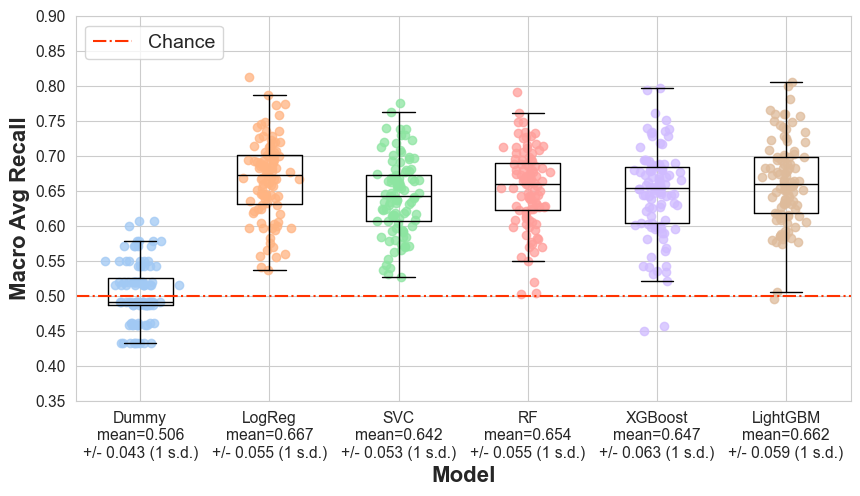

In [25]:
models_dict = {
        'Dummy'   : dummy,
        'LogReg'  : logreg_005,
        'SVC'     : svc_005,
        'RF'      : rf_005,
        'XGBoost' : xgb_005,
        'LightGBM': lgbm_005
}

model_preds_dict = {}
model_score_stats = []

recall_macro_scorer = make_scorer(recall_score, average='macro')

for name, model in models_dict.items():

    X_ = X[mwu_005] if name != 'Dummy' else X
    y_ = y

    cv_metric_scores = cross_val_score(
                                    estimator    = model,
                                    X            = X_,
                                    y            = y_,
                                    n_jobs       = -1,
                                    cv           = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 42),
                                    scoring      = recall_macro_scorer
    )
    model_preds_dict[name] = cv_metric_scores
    model_score_stats.append((name, cv_metric_scores.mean(), cv_metric_scores.std()))

model_preds_df = pd.DataFrame(model_preds_dict)

vals, names, xs = [],[],[]
for i, col in enumerate(model_preds_df.columns):
    vals.append(model_preds_df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.075, model_preds_df[col].values.shape[0])) # adds jitter to the data points - can be adjusted (i + 1, 0.04)

plt.figure(figsize=(10, 5))
plt.boxplot(vals, labels=names, medianprops={'color':'black'}, showfliers=False)
palette2 = sns.color_palette('pastel', n_colors=len(names))
for x, val, c in zip(xs, vals, palette2):
    plt.scatter(x, val, alpha=0.75, color=c)

#plt.title('Model Performance Across Varying Data Splits\n(MWU α < 0.05)', weight='bold')
plt.ylabel('Macro Avg Recall', weight='bold', fontsize=16)
plt.xlabel('Model', weight='bold', fontsize=16)
plt.axhline(y=0.5, color='#ff3300', linestyle='-.', label='Chance')
# Manually set y-axis ticks from 0.35 to 1, in steps of 0.05
plt.yticks(np.arange(0.35, 0.95, 0.05), fontsize=11.25)
# include mean and std in xticklabels:
xticklabels = [f'{name}\nmean={mean:0.3f}\n+/- {std:0.3f} (1 s.d.)' for name, mean, std in model_score_stats]
plt.xticks(ticks=np.arange(1, len(names)+1), labels=xticklabels, fontsize=11.25)
plt.legend(loc='upper left', fontsize=14)
plt.show();

## 5) **Global Shapley Values**
---
- >`Select model with highest mean in performance metric and least variability!`

#### RandomForest:

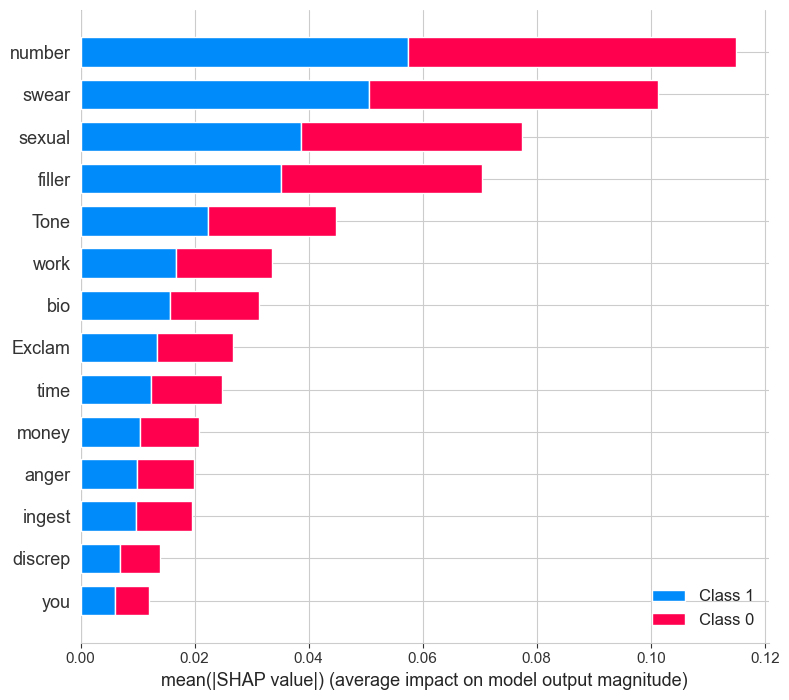

In [59]:
import shap

model = rf_005.named_steps['estimator']
# set figsize
plt.figure(figsize=(10, 3))
shap_values = shap.TreeExplainer(model).shap_values(X_train_drug[mwu_005])

shap.summary_plot(shap_values, X_train_drug[mwu_005], plot_type="bar", show=True, max_display=14)

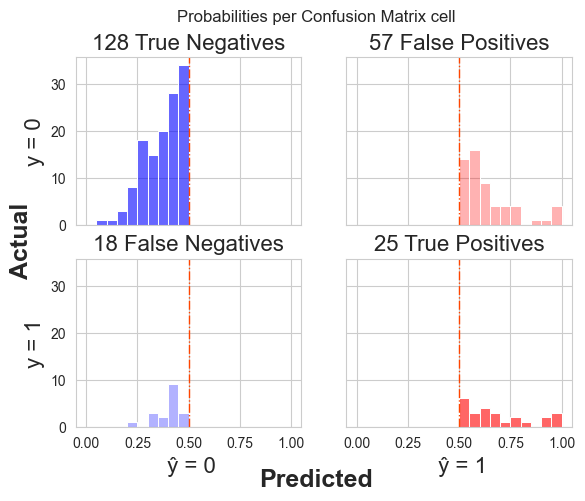

In [12]:
y_pred_proba = logreg_005.predict_proba(X_test_drug[mwu_005])

df_predictions = pd.DataFrame({'y': y_test_drug, 'y_proba': y_pred_proba[:,1]})
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# show true-pos

bins = np.arange(0, 1.01, 0.05)

def show_quarter(df, query, col, title, ax, bins, color, alpha, x_label=None, y_label=None):
    results = df.query(query)
    #results[col].hist(ax=ax, bins=bins);
    sns.histplot(results[col], kde=False, ax=ax, bins=bins, color=color, alpha=alpha)
    if y_label:
        ax.set_ylabel(y_label, fontsize=16)
    if x_label:
        ax.set_xlabel(x_label, fontsize=16)
    #ax.set_title(title + " ({})".format(results.shape[0]), fontsize=16)
    ax.set_title(f'{results.shape[0]} {title}', fontsize=16)
    # vertical line at 0.5
    ax.axvline(x=0.5, color='orangered', linestyle='-.', linewidth=1)

show_quarter(df_predictions, " y==0 and y_proba < 0.5", "y_proba", "True Negatives", axs[0][0], bins, color='blue', alpha=0.6, y_label="y = 0")
show_quarter(df_predictions, " y==0 and y_proba >= 0.5", "y_proba", "False Positives", axs[0][1], bins, color='red', alpha=0.3)
show_quarter(df_predictions, " y==1 and y_proba >= 0.5", "y_proba", "True Positives", axs[1][1], bins, color='red', alpha=0.6, x_label=" ŷ = 1")
show_quarter(df_predictions, " y==1 and y_proba < 0.5", "y_proba", "False Negatives", axs[1][0], bins, x_label=" ŷ = 0", color='blue', alpha=0.3, y_label="y = 1")

# Set common labels
fig.text(0.5, 0.000001, 'Predicted', ha='center', va='center', fontsize=18, weight='bold')
fig.text(0.04, 0.5, 'Actual', ha='center', va='center', rotation='vertical', fontsize=18, weight='bold')


fig.suptitle("Probabilities per Confusion Matrix cell");

In [50]:
proba_y_test_clf = rf_005.predict_proba(X_test_drug[mwu_005])[:,1]
df_test = pd.DataFrame({'proba': proba_y_test_clf}, index=X_test_drug.index)
df_test['truth'] = y_test_drug.values
df_test['abs_error'] = (df_test.truth - df_test.proba).abs()
df_test.head(5)

,proba,truth,abs_error
926,0.463047,0,0.463047
886,0.425602,0,0.425602
264,0.567028,1,0.432972
925,0.387380,0,0.387380
210,0.587116,0,0.587116


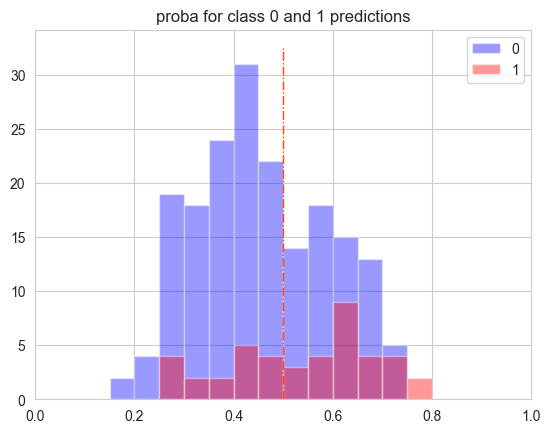

In [55]:
fig, ax = plt.subplots()
bins = np.arange(0, 1.01, 0.05)
df_test.query("truth==0")['proba'].hist(ax=ax, color='blue', alpha=0.4, bins=bins, label="0")
df_test.query("truth==1")['proba'].hist(ax=ax, color='red', alpha=0.4, bins=bins, label="1");
ax.legend()
ax.vlines(0.5, 0, ax.get_ylim()[1], color='orangered', linestyle='-.', linewidth=1)
ax.set_xlim((0, 1.0));
ax.set_title("proba for class 0 and 1 predictions");

#### XGBoost

[14:31:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


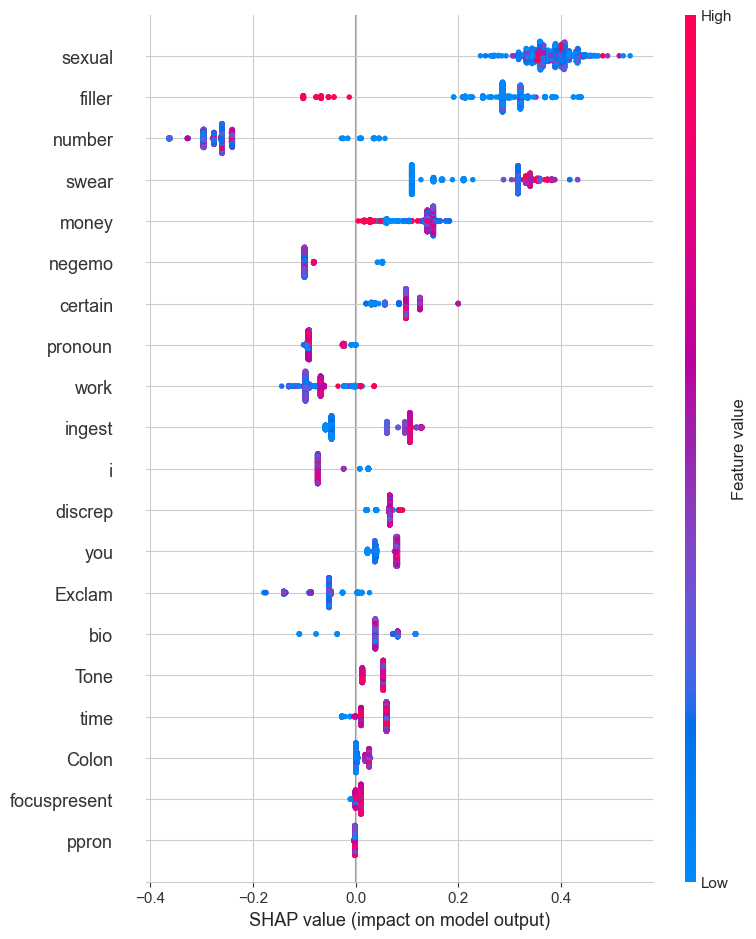

In [23]:
model = xgb_005.named_steps['estimator']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_drug[mwu_005])

shap.summary_plot(shap_values, X_train_drug[mwu_005], plot_type="dot")

In [29]:
# import learning curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, balanced_accuracy_score

# Create CV training and test scores for various training set sizes for XGBoost

train_sizes, train_scores, test_scores = learning_curve(
        estimator   = lgbm_005,
        X           = X_train_drug[mwu_005],
        y           = y_train_drug,
        train_sizes = np.linspace(0.1, 1.0, 10),
        cv          = StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        scoring     = make_scorer(balanced_accuracy_score),
        shuffle = True,
        n_jobs      = -1,
        verbose     =  1
)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std  = np.std(test_scores, axis=1)

# Draw lines
plt.subplots(figsize=(7, 5))
plt.plot(train_sizes, train_mean, marker='o', linestyle='-', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, marker='o', linestyle='-', color="red", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="dodgerblue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orangered", alpha=0.2)

# Create plot
plt.title("Learning Curve", weight='bold')
plt.xlabel("Training Set Size", weight='bold')
plt.ylabel("Balanced Accuracy Score", weight='bold')
plt.yticks(np.arange(0.4, 1.0, 0.05))
plt.legend(loc="best")
plt.tight_layout()
plt.show();


NameError: name 'lgbm_005' is not defined